## № 3

Consider the model in Eq. (1) with stationary but unknown $\sigma$ and $\rho$ and constant velocity, $u\equiv 1$. You are given a series of $T$ observations $z_1,...,z_T$ in `10_3.pickle` [pickled dict of $z_t$]. Your task is to estimate the parameters $\sigma$ and $\rho$ using the EM (expectation–maximization) algorithm.

$$
x_{t}=x_{t-1} + u_{t-1} + \epsilon_{t-1},\quad z_{t}=x_{t} + \eta_{t}
\tag{1}
$$

In [3]:
using PyCall

py"""
import pickle
 
def load_pickle(fpath):
    with open(fpath, "rb") as f:
        data = pickle.load(f)
    return data
"""

data = py"load_pickle"("10_3.pickle")

Dict{Any, Any} with 1 entry:
  "z" => [-3.93263, -1.61658, -5.32706, -2.53173, -5.25053, 0.239726, 5.37139, …

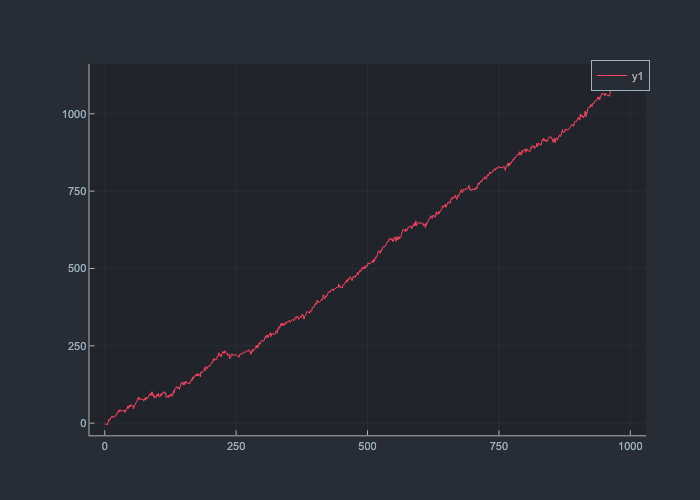

In [4]:
using Plots
plotlyjs()
theme(:juno)

z = data["z"]
plot(z)

Прежде чем мы начнем, сделаем догадку о значениях $\rho$ и $\sigma$. Заметим, что
$$
z_t - z_{t-1} \sim \mathcal{N}(u, \sigma^2 + 2\rho^2)
$$

Если дпополнительно предположить, что $\sigma \approx \rho$, то получится следующая оценка по порядку величины:

In [49]:
using Statistics: cov

initial_guess = √(cov(diff(z)) / 3)

2.9908298212822007

### Part 1

Derive expression for the log-likelihood $\ln L(x, z, \sigma, \rho)$ where $x$ and $z$ are the hidden state and observed time series.

Решение

Функция правдоподобия равна
$$
\begin{aligned}
L & = \prod_{t=1}^{T-1}
\frac{1}{\sqrt{2 \pi} \sigma}
\exp\biggl(-\frac{(x_t - x_{t-1} - u)^2}{2\sigma^2}\biggr)
\prod_{t=0}^{T-1}
\frac{1}{\sqrt{2 \pi} \rho}
\exp\biggl(-\frac{(z_t - x_t)^2}{2\rho^2}\biggr) \\
& = \frac{1}{(2 \pi)^{T-1/2}}\frac{1}{\sigma^{T-1} \rho^T}
\exp\biggl(-\frac12 x^T Q x + x^T b \biggr)
\exp\biggl(-\frac{U}{2\sigma^2} - \frac{Z}{2\rho^2}\biggr)
\end{aligned}
$$

где:
$$
Q = \begin{pmatrix}
\frac{1}{\sigma^2} + \frac{1}{\rho^2} & -\frac{1}{\sigma^2} & 0 & \cdots & 0 \\
-\frac{1}{\sigma^2} & \frac{2}{\sigma^2} + \frac{1}{\rho^2} & -\frac{1}{\sigma^2} & \cdots & 0 \\
0 & -\frac{1}{\sigma^2} & \frac{2}{\sigma^2} + \frac{1}{\rho^2} & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & \frac{1}{\sigma^2} + \frac{1}{\rho^2}
\end{pmatrix}
\qquad
b =
\begin{pmatrix}
\frac{0 - u_0}{\sigma^2} + \frac{z_0}{\rho^2} \\
\frac{u_0 - u_1}{\sigma^2} + \frac{z_1}{\rho^2} \\
\frac{u_1 - u_2}{\sigma^2} + \frac{z_2}{\rho^2} \\
\vdots \\
\frac{u_{T-2}}{\sigma^2} + \frac{z_{T-1}}{\rho^2}
\end{pmatrix}
$$

$$
U = \sum_{t=1}^{T-1} u^2 = (T-1) u^2
\qquad
Z = \sum_{t=0}^{T-1} z_t^2
$$

Выражение для $L$ пропорционально PDF нормального распределения по $x$ c ковариационной матрицей $\Sigma = Q^{-1}$ и матожиданием $\mu = Q^{-1}b$.
$$
L \propto P = \mathcal{N}(Q^{-1} b,\ Q^{-1})
$$

Логарифм функции правдоподобия равен
$$
\ln L = - (T-1)\ln\sigma - T\ln\rho -\frac12 x^T Q x + x^T b - \frac{U}{2\sigma^2} - \frac{Z}{2\rho^2} + \text{const}
$$

Чтобы упростить дифференциирование, введём переменные $s = \sigma^{-2}$ и $r = \rho^{-2}$.

Тогда
$$
2 \ln L = (T-1) \ln s + T \ln r - x^T Q x + 2 x^T b - Us - Zr + \text{const}
$$

### Part 2

Pick some reasonable estimates for $\sigma$ and $\rho$ (lets denote them $\sigma_0$ and  $\rho_0$ correspondingly). Iterate the following two steps ($i=0,1,...$), until reasonable convergence:

* Compute expected value of $\ln L(x, z, \sigma, \rho)$ — that is, average over $x$ with the distribution, given by $x\sim P(x, z, \sigma_i, \rho_i)$. The result is a function $C_i(\sigma,\rho)$ of a very simple analytical form, only the coefficients are to be computed numerically.

* Maximize the function $C_i(\sigma,\rho)$ over its arguments and set $(\sigma_{i+1},\rho_{i+1}) = \mathrm{argmax}_{\sigma,\rho}C_i(\sigma,\rho)$.

Решение:

$$
\begin{aligned}
2C_i(\sigma,\rho) & =
\int 2 \ln L(x, \sigma, \rho) \; P_i (x) \, dx \\
& = \int \Bigl((T-1) \ln s + T \ln r - x^T Q x + 2 x^T b - Us - Zr \Bigr)\,
\mathcal{N}(\mu_i = Q_i^{-1}b_i,\ \Sigma_i = Q_i^{-1})\, dx
\end{aligned}
$$

Вычислим слагаемые в интеграле:
$$
\begin{aligned}
& E[x^T Q x] = \mu_i^T Q \mu_i + \operatorname{tr}(Q \Sigma_i) = \mu_i^T Q \mu_i + \operatorname{tr}(Q Q_i^{-1}) \\
& E[x^T b] = \mu_i^T b \\
& E[(T-1) \ln s + T \ln r - Us - Zr] = (T-1) \ln s + T \ln r - Us - Zr
\end{aligned}
$$

Таким образом,
$$
2C_i(\sigma,\rho) = - \operatorname{tr}(Q Q_i^{-1}) - \mu_i^T Q \mu_i + 2 \mu_i^T b + (T-1) \ln s + T \ln r - Us - Zr
$$

Найдём максимум $C_i$. Дифференциировать будем по введённым переменным $s = \sigma^{-2}$ и $r = \rho^{-2}$:
$$
\begin{aligned}
2 \frac{\partial C_i}{\partial s}
& = -\operatorname{tr}\Bigl(Q_i^{-1} \frac{\partial}{\partial s} Q\Bigr) - \mu_i^T \frac{\partial}{\partial s} Q \mu_i + 2 \mu_i^T \frac{\partial}{\partial s} b + \frac{T-1}{s} - U = 0 \\
2 \frac{\partial C_i}{\partial r}
& = -\operatorname{tr}\Bigl(Q_i^{-1} \frac{\partial}{\partial r} Q\Bigr) - \mu_i^T \frac{\partial}{\partial r} Q \mu_i + 2 \mu_i^T \frac{\partial}{\partial r} b + \frac{T}{r} - Z = 0
\end{aligned}
$$

Входящие сюда производные — константы:
$$
\begin{aligned}
\frac{\partial}{\partial s} Q
& = \begin{pmatrix}
1 & -1 & 0 & \cdots & 0 \\
-1 & 2 & -1 & \cdots & 0 \\
0 & -1 & 2 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & 1
\end{pmatrix}
\qquad
&& \frac{\partial}{\partial s} b
= \begin{pmatrix}
-u_0 \\ u_0 - u_1 \\ u_1 - u_2 \\ \vdots \\ u_{T-2}
\end{pmatrix} \\
\frac{\partial}{\partial r} Q & = \hat 1
&& \frac{\partial}{\partial r} b
= \begin{pmatrix}
z_0 \\ z_1 \\ z_2 \\ \vdots \\ z_{T-1}
\end{pmatrix}
\end{aligned}
$$

Таким образом, в точке максимума
$$
\begin{aligned}
s_{i+1} & = T \cdot \biggl(
    U + \operatorname{tr}\Bigl(Q_i^{-1} \frac{\partial}{\partial s} Q\Bigr) + \mu_i^T \frac{\partial}{\partial s} Q \mu_i - 2 \mu_i^T \frac{\partial}{\partial s} b
\biggr)^{-1} \\
r_{i+1} & = T \cdot \biggl(
    Z + \operatorname{tr}\Bigl(Q_i^{-1} \frac{\partial}{\partial r} Q\Bigr) + \mu_i^T \frac{\partial}{\partial r} Q \mu_i - 2 \mu_i^T \frac{\partial}{\partial r} b
\biggr)^{-1}
\end{aligned}
$$

In [34]:
using LinearAlgebra

function Q_and_μ(s, r, z::Vector)
    subdiagonal = -s * ones(length(z) - 1)

    main_diagonal = (2s + r) * ones(length(z))
    main_diagonal[1] = s + r
    main_diagonal[end] = s + r

    Q = SymTridiagonal(main_diagonal, subdiagonal)

    b = z * r
    b[1] -= s
    b[end] += s

    return Q, Q \ b
end

Q_and_μ (generic function with 1 method)

In [37]:
T = length(z)

U = (T - 1) * 1
Z = sum(z.^2);

In [38]:
dQ_ds = SymTridiagonal(2 * ones(length(z)), -ones(length(z) - 1))
dQ_ds[1, 1] = 1
dQ_ds[end, end] = 1

dQ_dr = I

db_ds = zeros(length(z)) # u ≡ 1
db_ds[1] = -1
db_ds[end] = 1

db_dr = z;

In [52]:
N = 15

Q = Vector{SymTridiagonal}(undef, N)
μ = Vector{Vector{Float64}}(undef, N)
s = Vector{Float64}(undef, N)
r = Vector{Float64}(undef, N)

s[1] = initial_guess^-2
r[1] = initial_guess^-2

for i ∈ 1:N-1
    Q[i], μ[i] = Q_and_μ(s[i], r[i], z)
    s[i + 1] = T / (U + tr(Q[i] \ dQ_ds) + μ[i]' * dQ_ds * μ[i] - 2μ[i]' * db_ds)
    r[i + 1] = T / (Z + tr(Q[i] \ dQ_dr) + μ[i]' * dQ_dr * μ[i] - 2μ[i]' * db_dr)
end

In [53]:
s

15-element Vector{Float64}:
 0.11179351087617384
 0.11570984298527554
 0.11873460053808182
 0.12118817637701058
 0.12324733548621288
 0.12501120477242644
 0.12653870928901828
 0.1278682116590394
 0.1290273844734158
 0.1300380423349248
 0.13091846835766086
 0.13168453128059862
 0.13235023564135376
 0.13292801503574941
 0.1334289136022121

In [54]:
r

15-element Vector{Float64}:
 0.11179351087617384
 0.11178396082388808
 0.11112259862733397
 0.11023196759969897
 0.10931369784895925
 0.1084550798202956
 0.10768754815187892
 0.1070166881977746
 0.10643701480342639
 0.10593900382690798
 0.10551229843461629
 0.10514707190514998
 0.10483452547277584
 0.10456699610179379
 0.10433790000591815

Видно, что алгоритм сошёлся. Соответствующие значения $\sigma$ и $\rho$ равны:

In [56]:
1 / √s[end], 1 / √r[end]

(2.7376317249021733, 3.095843186290066)